In [1]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)
from tqdm import tqdm

num_times = 390
start_dt = datetime(2000, 1, 1, 9, 30)  # arbitrary date

time = [ (start_dt + timedelta(minutes=min)).time().strftime("%H:%M") for min in range(num_times)]

def create_file_and_print(prices, volume, file_name = None, is_plot=True):
    global time
    
    # common code for creating the data_frame and the graph
    round_decimals = 4
    open = np.round( prices[:-1], decimals= round_decimals )
    close = np.round( prices[1:], decimals= round_decimals )
    high = np.round(np.maximum(open,close), decimals = round_decimals )
    low =np.round( np.minimum(open, close), decimals = round_decimals ) 
    
    df = pd.DataFrame(data = {
        "Time": time,
        "Close": close,
        "High": high,
        "Low": low,
        "Open": open,
        "Volume": volume  # Add volume column
    })
    df["Time"] = df["Time"].astype("string")

    # Visualize
    if is_plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        ax1.plot(range(num_times), close, label='Price')
        ax1.set_title('Price vs Time')
        ax2.bar(range(num_times), volume, color='gray', alpha=0.8)
        ax2.set_title('U-Shaped Volume Profile')
        plt.tight_layout()
        plt.show()

    if file_name is not None: 
        df.to_csv(file_name, header=True, index=False)

t = np.arange(num_times)
mid_index = num_times // 2 
min_volume = 1000
max_volume = 10000  # Peak volume at open/close
power = 20
volume_profile = min_volume + (max_volume - min_volume) * ((t - mid_index) / mid_index)**power

# add some randomess
target = 0.4  # or empirical from real data
sigma = target * np.sqrt(np.pi) / 2
epsilon = np.random.normal(0, sigma, size=num_times)
volume_profile*=np.exp(epsilon)
volume_profile = np.round(volume_profile).astype(int)

# add different kinds of lines
lines_dict = {}
start_price = 100
num_prices = 391
mid_point = int(num_prices//2)
first_third_point = int(num_prices//3)
second_third_point = int(2*num_prices//3)
overall_day_change = 0.05 # a percent change over the entire day, if pure increase then a 15% increase
noise_percent = 0.0012 # noise/start_price

lines_dict["increase"] = np.linspace(start=start_price, stop=start_price*(1+overall_day_change), num= num_prices) + np.sin(range(num_prices))*noise_percent*start_price
lines_dict["decrease"] = np.linspace(start=start_price, stop=start_price*(1-overall_day_change), num= num_prices)+ np.sin(range(num_prices))*noise_percent*start_price
lines_dict["unchange"] = np.linspace(start=start_price, stop=start_price, num= num_prices)+ np.sin(range(num_prices))*noise_percent*start_price



In [2]:
def simulate_ou_process(start_price: float, duration: int, theta: float = 0.0005, sigma: float = 0.0002, mu: float = 0.0):
    """
    Simulate an Ornstein-Uhlenbeck (mean-reverting) price process.

    Args:
        start_price (float): Initial price at time t = 0.
        duration (int): Number of time steps to simulate.
        theta (float): Mean-reversion speed. 
        sigma (float): Volatility (noise scale).
        mu (float): Drift or long-run mean target.

    Returns:
        np.ndarray: Simulated price series of length `duration`.
    """
    # Validate inputs
    if duration <= 0:
        raise ValueError("`duration` must be a positive integer")

    # Initialize different arrays
    mean_series = start_price * (1 + np.arange(duration) * (mu / duration))
    theta_series = np.full(duration, float(theta), dtype=float)
    sigma_series = np.full(duration, float(sigma), dtype=float)
    
    # Initialize price array, add a bit of randomness to the first element
    prices = np.zeros(duration, dtype=float)
    prices[0] = start_price + sigma_series[0]*np.random.standard_normal()
    
    # Simulate OU process
    for t in range(1, duration):
        drift = theta_series[t] * (mean_series[t] - prices[t - 1])
        noise = sigma_series[t] * np.random.standard_normal()
        prices[t] = prices[t - 1] + drift + noise

    return prices

In [3]:
np.random.seed(999)

# These numbers so chosen that there are 1-4 trends in each profiles and the final check ensures all trends are positive
num_trend_samples = 500
mu = 0.67
sigma = 0.4
trends = (np.random.normal(mu, sigma, num_trend_samples)*num_prices).astype(int)
trends.sort()
trends = trends[trends>0] # exclude 0 or negative length trends

# profile parameters
mu_min = 0.00
mu_max = 0.01

theta_slow = 0.0001
theta_fast = 0.04

sigma_min = 0.01
sigma_max = 0.2

num_profiles = 500

a_curr = 0.9448074995322336
b_curr = 0.6687403049764219

""" ## NOTE: comment and uncomment the following code for generating a and b values"""

# a_ranges = np.geomspace(a_curr/2, a_curr*2, num=25)
# b_ranges = np.geomspace(b_curr/2, b_curr*2, num=25)
# m_star = 0.6750734305570594
# s_star = 0.483997555382571
# best = {"loss": float("inf"), "a": None, "b": None, "m": None, "s": None}

# for a in tqdm(a_ranges, desc="Scanning a"):
#     for b in b_ranges:
#         avg_price_movements = []
        
#         for file_ind in range(num_profiles):
#             trend_lens = []
#             while sum(trend_lens) < num_prices:
#                 trend_lens.append(np.random.choice(trends))
#             # remove the last element since it overshot num_prices and replace it with the revelant length
#             trend_lens[-1] = num_prices - sum(trend_lens[:-1])
            
#             prices = np.array([])
#             trend_mus = []
            
#             u = np.random.beta(a, b)   
#             sigma = sigma_min * (sigma_max/sigma_min)**u
            
#             theta = np.random.uniform(theta_slow, theta_fast)
            
#             for trend in trend_lens:
#                 mu = np.random.uniform(mu_max, mu_max)*np.random.choice([-1,1]) # an increasing decreasing mean
#                 trend_mus.append(mu)
#                 if prices.size == 0:
#                     curr_prices = simulate_ou_process(start_price=start_price , duration=trend, theta=theta, sigma=sigma, mu=mu)
#                 else:
#                     curr_prices = simulate_ou_process(start_price=prices[-1], duration=trend, theta=theta, sigma=sigma, mu=mu)
#                 prices = np.concatenate([prices, curr_prices], axis=0)
                
#             avg_price_movements.append( 1000*np.mean(np.abs( np.diff(np.log(prices)) )) )
        
#         m = np.mean(avg_price_movements)
#         s = np.std(avg_price_movements)
        
#         loss = (m - m_star)**2 + (s - s_star)**2
#         if loss < best["loss"]:
#             best.update({"loss": loss, "a": a, "b": b, "m": m, "s": s})

# print(best)

""" Following code is used to generate the files. """
for file_ind in range(num_profiles):
    trend_lens = []
    while sum(trend_lens) < num_prices:
        trend_lens.append(np.random.choice(trends))
    # remove the last element since it overshot num_prices and replace it with the revelant length
    trend_lens[-1] = num_prices - sum(trend_lens[:-1])
    
    prices = np.array([])
    trend_mus = []
    
    u = np.random.beta(a_curr, b_curr)   
    sigma = sigma_min * (sigma_max/sigma_min)**u
    
    theta = np.random.uniform(theta_slow, theta_fast)
    
    for trend in trend_lens:
        mu = np.random.uniform(mu_max, mu_max)*np.random.choice([-1,1]) # an increasing decreasing mean
        trend_mus.append(mu)
        if prices.size == 0:
            curr_prices = simulate_ou_process(start_price=start_price , duration=trend, theta=theta, sigma=sigma, mu=mu)
        else:
            curr_prices = simulate_ou_process(start_price=prices[-1], duration=trend, theta=theta, sigma=sigma, mu=mu)
        prices = np.concatenate([prices, curr_prices], axis=0)
    
    # if file_ind%1==0: plt.plot(prices)
    
    directions = ["up" if μ>0 else "down" for μ in trend_mus]
    file_name = (
        r"../Cirricula/Phase 1/"
        f"profile_{file_ind:02d}"
        f"_{len(trend_lens)}_segments"
        f"_{'_'.join(directions)}"
    )
    create_file_and_print(prices=prices, volume=volume_profile, file_name=file_name, is_plot=False)



In [4]:
"""
Create the date_file.txt
"""

from pathlib import Path

root = Path(r"../Cirricula/Phase 1")
raw_files: set[Path] = set()

for file in root.rglob("*"):
    if file.name == "date_file.txt": continue
    raw_files.add(file)
    
# replace create date_file and write to it
with open(r"../Cirricula/Phase 1/date_file.txt", "w") as date_file:
    # for each file in rawfile write hold and then the file name
    for file in raw_files:
        date_file.write(file.name+"\n")

[0.12223352 0.12492447 0.12718729 0.12744059 0.12875918 0.12979004
 0.13040859 0.13169474 0.13200128 0.13203762 0.1352745  0.13708082
 0.1371094  0.13728569 0.13753483 0.13765271 0.13832545 0.13893191
 0.13928327 0.14052975 0.14118611 0.14144959 0.14208635 0.14233163
 0.142484   0.14512667 0.14729028 0.14780247 0.14783029 0.14816412
 0.14962468 0.1503206  0.15129583 0.15268149 0.15276636 0.15287996
 0.15434336 0.15529671 0.15538735 0.15595985 0.15821537 0.15978311
 0.16038462 0.16040692 0.16080153 0.16176878 0.16603342 0.16685785
 0.1670296  0.16744373 0.16871498 0.17035026 0.17048658 0.1714522
 0.17225416 0.17266413 0.17325035 0.17380334 0.17599188 0.17733949
 0.1785869  0.18052745 0.18176518 0.1842372  0.18474512 0.18542995
 0.18605895 0.18709554 0.18746904 0.18786079 0.18974956 0.19047334
 0.19062883 0.19293877 0.19489363 0.19492303 0.19551604 0.19609757
 0.19749857 0.19905733 0.19995913 0.20075534 0.20338108 0.20427942
 0.20745723 0.20765865 0.21005402 0.2118173  0.21295698 0.21430

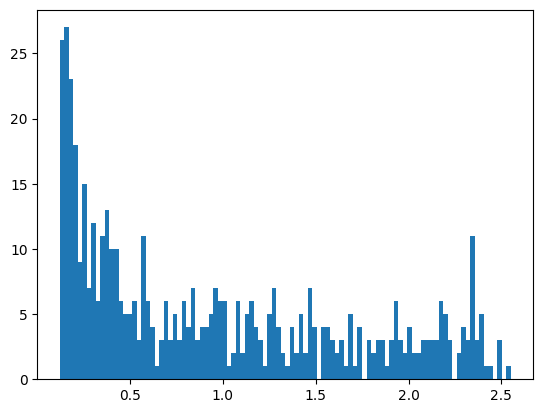

In [25]:
""" 
Check dlog values for actual data volume and prices
"""

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root = Path(r"../US_Market_Data")
root = Path(r"../Cirricula/Phase 1")
count=0
avg_price_movements = []
avg_volume_movements = []

for file in root.rglob("*"):
    if file.is_dir() or file.name == "date_file.txt":continue
    df = pd.read_csv(file, index_col=0, header=0)
    
    open = df["Open"]
    close = df["Close"]
    high = df["High"]
    low = df["Low"]
    volume = df["Volume"]
    avg_price_movements.append( 1500*np.mean(np.abs( np.log(close/open) )) )
    # avg_volume_movements.append( np.mean(np.abs( np.log(close/open) )) )
    # if count%10==0:
    #     print(f"avg dlog price: {1000*np.mean(np.abs( np.log(close/open) ))}")
    #     print(f"avg dlog volume: {np.mean(np.abs(np.log(volume/volume_profile)))}")
    count+=1    
    
avg_price_movements = np.array(avg_price_movements)
avg_price_movements.sort()
avg_price_movements = avg_price_movements[avg_price_movements<3]
print(avg_price_movements)
print(f"Mean price movement in {root.name}: {np.mean(avg_price_movements)}")
print(f"Std price movement in {root.name}: {np.std(avg_price_movements)}")
plt.hist(avg_price_movements, bins=100)
plt.show()

In [20]:
# Mean price movement in US_Market_Data: 0.6750734305570594
# Std price movement in US_Market_Data: 0.483997555382571

In [2]:
import numpy as np
eta_start = 1e-6
eta_end = 1e-1
P = 20
np.geomspace(eta_start, eta_end, num=P)

array([1.00000000e-06, 1.83298071e-06, 3.35981829e-06, 6.15848211e-06,
       1.12883789e-05, 2.06913808e-05, 3.79269019e-05, 6.95192796e-05,
       1.27427499e-04, 2.33572147e-04, 4.28133240e-04, 7.84759970e-04,
       1.43844989e-03, 2.63665090e-03, 4.83293024e-03, 8.85866790e-03,
       1.62377674e-02, 2.97635144e-02, 5.45559478e-02, 1.00000000e-01])